In [1]:
import os
import pandas as pd
import numpy as np
import random
import gc
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.feature_extraction.text import TfidfVectorizer
from  collections import Counter

np.random.seed(2019)
random.seed(2019)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 280)
pd.set_option('display.max_colwidth', 150)
data_path = '/data/workspace/kimi/tencent_ads/2020/dataset'
preprocess_path = 'preprocess'

In [2]:
clk_df = pd.read_csv(f'{data_path}/train_preliminary/click_log.csv' )
clk_test_df = pd.read_csv(f'{data_path}/test/click_log.csv' )
clk_df = pd.concat([clk_df,clk_test_df],axis=0)
print(clk_df)


          time  user_id  creative_id  click_times
0            9    30920       567330            1
1           65    30920      3072255            1
2           56    30920      2361327            1
3            6   309204       325532            1
4           59   309204      2746730            1
...        ...      ...          ...          ...
33585507    16  3131989       585914            1
33585508    13  3131989       749134            1
33585509    12  3131989       589027            1
33585510    61  3131989      2404831            1
33585511    14  3131989       665822            1

[63668283 rows x 4 columns]


1900000
3648518    113974
3834944     26609
3093561     25506
3206914     18178
839368      16868
3522917     11116
3548147     10318
3038145      2295
3094381      2108
3066940      2064
Name: user_id, dtype: int64
773026     9
3349831    9
278200     9
677060     9
3946806    9
          ..
3807588    9
3853772    9
3013416    9
59951      9
3122069    9
Name: user_id, Length: 1000, dtype: int64
589192     10
3429569    10
3534670    10
441608     10
382026     10
           ..
639004     10
3099251    10
3797556    10
698481     10
862337     10
Name: user_id, Length: 10000, dtype: int64
483853     15
3334857    15
332009     15
3596320    15
85395      15
           ..
3111794    14
3473810    14
3714847    14
3620391    14
3025307    14
Name: user_id, Length: 100000, dtype: int64
3417072    44
3363780    44
182752     44
711447     44
392665     44
           ..
867303     39
518881     39
80412      39
631005     39
3799058    39
Name: user_id, Length: 100000, dtype: int64
p[0.1]

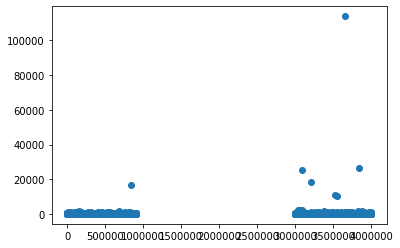

In [25]:
adv_count_value= clk_df['user_id'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
print(adv_count_value[-10000:-9000])
print(adv_count_value[-50000:-40000])
print(adv_count_value[-500000:-400000])
print(adv_count_value[-1500000:-1400000])
for v in [(i+1)*0.1 for i in range(10)] + [ (i+1)*0.01 + 0.9 for i in range(9)] + [ (i+1)*0.001 + 0.99 for i in range(9)]:
    q = adv_count_value.quantile(v)
    print(f'p[{round(v,3)}]:{q}')
#adv_count_value = adv_count_value[adv_count_value.values < 200]

#null_counts = adv_count_value['\\N']
#print(f"null:{null_counts}")
x = adv_count_value.index
y = adv_count_value.values
arr = np.array(adv_count_value.values)
print(len(arr))
print(np.mean(arr))
print(np.median(arr))
print(np.std(arr))

plt.scatter(x,y)
plt.show()


91
85    885349
78    860217
84    834380
64    822412
57    809818
74    805973
63    795623
91    795028
34    789308
36    787226
Name: time, dtype: int64
Int64Index([85, 78, 84, 64, 57, 74, 63, 91, 34, 36, 31, 77, 73, 43, 35, 75, 65, 37, 32, 71, 33, 56, 79, 67, 50, 70, 88, 49, 90, 66, 81, 82, 83, 72, 14, 68, 86, 76, 80, 55, 60, 54, 69, 87, 42, 58, 53, 61, 45, 52, 46, 22, 59, 48, 40, 30, 89, 47, 41, 51, 62, 15, 29, 44, 13, 21, 39,
            18, 28, 38,  1, 17, 26,  8, 19, 16, 25, 11, 27, 23,  7, 24,  2, 12, 10, 20,  3,  4,  5,  9,  6],
           dtype='int64')


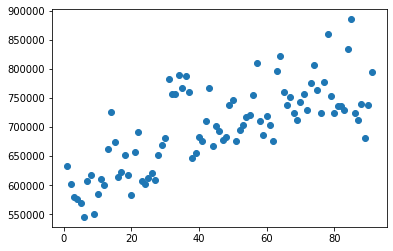

In [4]:
adv_count_value= clk_df['time'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
#null_counts = adv_count_value['\\N']
#print(f"null:{null_counts}")
x = adv_count_value.index
print(x)
y = adv_count_value.values
plt.scatter(x,y)
plt.show()

         user_id  click_times_total
384504    384505                 10
953168   3053169                 10
953110   3053111                 10
1616483  3716484                 10
1616485  3716486                 10
...          ...                ...
839367    839368              21330
1106913  3206914              23328
993560   3093561              33372
1734943  3834944              35283
1548517  3648518             194614

[1900000 rows x 2 columns]


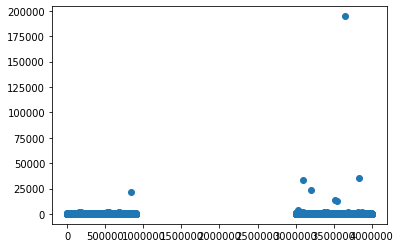

In [5]:
user_click_sum_df = clk_df.groupby(['user_id']).click_times.sum().reset_index().rename(columns={'click_times':'click_times_total'}).sort_values(by='click_times_total')
print(user_click_sum_df)
x = user_click_sum_df['user_id'].values.tolist()
y = user_click_sum_df['click_times_total'].values.tolist()
plt.scatter(x,y)
plt.show()

    time  day_uv
8      9  378171
5      6  378438
19    20  395584
9     10  398591
4      5  399385
..   ...     ...
63    64  512956
56    57  513564
73    74  519004
77    78  527583
84    85  539616

[91 rows x 2 columns]


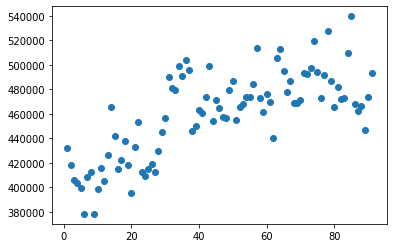

In [6]:
day_uv_df = clk_df.groupby(['time']).user_id.nunique().reset_index().rename(columns={'user_id':'day_uv'}).sort_values(by='day_uv')
print(day_uv_df)
x = day_uv_df['time'].values.tolist()
y = day_uv_df['day_uv'].values.tolist()
plt.scatter(x,y)
plt.show()

    time  creative_id
0      1            4
1      2            7
2      3            5
3      4            5
4      5            3
..   ...          ...
84    86            3
85    87            1
86    88            4
87    89            1
88    91            1

[89 rows x 2 columns]


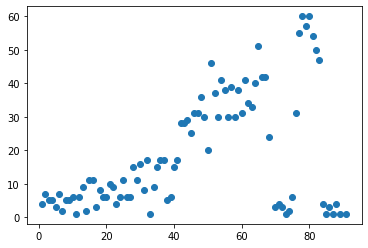

In [7]:
user_p_df  = clk_df[clk_df.user_id == 157585].groupby(['time']).click_times.count().reset_index().rename(columns={'click_times':'creative_id'})
print(user_p_df)
x = user_p_df['time'].values.tolist()
y = user_p_df['creative_id'].values.tolist()
plt.scatter(x,y)
plt.show()

   time  creative_id
0     2            1
1     8            1
2    30            2
3    31            2
4    73            4


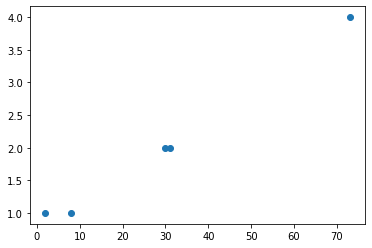

In [8]:
user_ps_df  = clk_df[clk_df.user_id == 727101].groupby(['time']).click_times.sum().reset_index().rename(columns={'click_times':'creative_id'})
print(user_ps_df)
x = user_ps_df['time'].values.tolist()
y = user_ps_df['creative_id'].values.tolist()
plt.scatter(x,y)
plt.show()

In [9]:
ad_df = pd.read_csv(f'{data_path}/train_preliminary/ad.csv' )

In [10]:
user_ins_df = clk_df[clk_df.user_id == 157585]
user_ins_df= user_ins_df.merge(ad_df,on='creative_id').sort_values(by='time')
print(user_ins_df)

      time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry
209      1   157585       238194            1   214100       1766                 2          39495       \N
562      1   157585       130042            1   116893      26858                 3           9458       60
354      1   157585        90587            2    82798      26858                 3           9458       60
661      1   157585        33446            1    32746      42008                17          18910       \N
213      2   157585       275192            1   247733         \N                18          14681      326
...    ...      ...          ...          ...      ...        ...               ...            ...      ...
1130    88   157585      2147997            1  1854843       9108                 3           2535      319
70      88   157585      4041528            1  3469295      37257                 4          21049       \N
177     88   157585      405

In [11]:
user_ins_df = clk_df[clk_df.user_id == 727101]
user_ins_df= user_ins_df.merge(ad_df,on='creative_id').sort_values(by='time')
print(user_ins_df)

   time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry
3     2   727101       119552            1   107970         \N                18          14681      297
7     8   727101       490785            1   437024         \N                18          17601       40
4    30   727101       383719            1   342799       1766                 2          34383      319
6    30   727101      1574717            1  1367152       1766                 2          42161      319
1    31   727101      1242486            1  1086873         94                 2          45848      245
8    31   727101      1121707            1   983648         \N                18          14681      216
0    73   727101      3358504            2  2889902       2400                 2          43538      246
2    73   727101      2635675            1  2268491       2400                 2          50845      246
5    73   727101      3535429            1  3044914    

In [12]:
user_ins_df = clk_df[clk_df.user_id == 420997]
user_ins_df= user_ins_df.merge(ad_df,on='creative_id').sort_values(by='time')
print(user_ins_df)

   time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry
9     3   420997        22126            1    22978         \N                12          10986      205
3     6   420997        31216            1    30911         \N                12          22400       54
5    41   420997      1768435            1  1531319      26976                 3            883      183
7    46   420997      1866093            1  1615591      39324                 4          28151       \N
8    69   420997      3378741            1  2907650        643                 3           2623        6
0    72   420997      2915786            1  2506618         \N                18          14681        6
4    73   420997      3510165            1  3023093         \N                18          14682        6
2    74   420997      3102293            1  2668742         \N                18          14681        6
6    77   420997      3541006            1  3049265    

In [13]:
user_ins_df = clk_df[clk_df.user_id == 737997]
user_ins_df= user_ins_df.merge(ad_df,on='creative_id').sort_values(by='time')
pd.set_option('display.max_rows', 100)
print(user_ins_df)
pd.set_option('display.max_rows', 10)

    time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry
4      5   737997       230303            1   206776      41655                17          30122       \N
3      6   737997       230303            1   206776      41655                17          30122       \N
21     8   737997       331825            1   298107      41655                17          30124       \N
11     8   737997       230844            1   207295      41655                17          30124       \N
24    23   737997       621801            1   552149         \N                18            847       27
20    25   737997       136085            1   122288         \N                18          37156       13
0     26   737997       422565            1   376603         \N                18          24675       47
22    35   737997       160316            1   143752         \N                18            899       27
8     50   737997      2386964            2  2

In [14]:
user_ins_df = clk_df[clk_df.user_id == 323781]
user_ins_df= user_ins_df.merge(ad_df,on='creative_id').sort_values(by='time')
pd.set_option('display.max_rows', 100)
print(user_ins_df)
pd.set_option('display.max_rows', 10)

    time  user_id  creative_id  click_times    ad_id product_id  product_category  advertiser_id industry
24     2   323781       127222            1   114519      26858                 3          29869       60
19     3   323781       318574            1   286229         \N                 5          19862        6
1      4   323781       320256            1   287821         \N                 5          13872       89
10     4   323781       201221            1   180675         \N                 5          18784      205
20     5   323781       303160            1   272203         \N                 5          36186       88
15    27   323781      1354554            1  1183922       9170                 3          43415      253
22    35   323781      1414984            1  1234451      26858                 3          19622       60
13    35   323781       619158            1   549778      26858                 3          19622       60
25    36   323781      1354136            1  1

In [15]:
merged_df = clk_df.merge(ad_df,on='creative_id')
merged_df.replace("\\N",-1,inplace=True)
merged_df.fillna(-1).astype(float)
merged_df['wday'] = merged_df['time'].apply(lambda x :int(x /7))
merged_df['month'] = merged_df['time'].apply(lambda x :int(x /30))
print(merged_df)

KeyboardInterrupt: 

In [ ]:
adv_count_value= merged_df['product_category'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
null_counts = adv_count_value.get(-1, 0)
print(f"null:{null_counts}")
x = adv_count_value.index
y = adv_count_value.values
plt.scatter(x,y)
plt.show()

In [ ]:
adv_count_value= merged_df['industry'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
null_counts = adv_count_value.get(-1, 0)
print(f"null:{null_counts}")
x = [str(i) for i in adv_count_value.index]
y = adv_count_value.values
plt.scatter(x,y)
plt.show()

In [ ]:
adv_count_value= merged_df['advertiser_id'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
null_counts = adv_count_value.get(-1, 0)
print(f"null:{null_counts}")
# x = [str(i) for i in adv_count_value.index]
# y = adv_count_value.values
# plt.scatter(x,y)
# plt.show()

In [ ]:
adv_count_value= merged_df['product_id'].value_counts()
print(len(adv_count_value))
print(adv_count_value[:10])
null_counts = adv_count_value.get(-1, 0)
print(f"null:{null_counts}")
# x = [str(i) for i in adv_count_value.index]
# y = adv_count_value.values
# plt.scatter(x,y)
# plt.show()